In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import random
from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Prepare data

In [2]:
# rolling mean at 1 month means no rolling mean
rolling_months = 1

# change AMV lead months
lead = 12

# if shuffle data
shuffle = True

# if set seed for random 
deterministic = True

# normalization method
norm = "std"

In [3]:
# read in data
amoc_full = np.load('Data/CESM1LE_AMOCIndex_1920-2005_region20to30_componentall_detrend0.npy')
nao_full = np.load('Data/CESM1LE_NAOIndex_1920-2005_detrend0.npy')[:,:,0]
amv_full = np.load('Data/CESM1LE_AMVIndex_1920-2005_detrend0_filter0.npy')

# perform rolling mean
amoc_rolling = pd.DataFrame(data=amoc_full.T).rolling(rolling_months).mean().values.T
nao_rolling = pd.DataFrame(data=nao_full.T).rolling(rolling_months).mean().values.T
amv_rolling = pd.DataFrame(data=amv_full.T).rolling(rolling_months).mean().values.T

# calculate mean and std for normalization
amoc_mean = np.nanmean(amoc_rolling,axis=1)
amoc_std = np.nanstd(amoc_rolling,axis=1)
amoc_min = np.nanmin(amoc_rolling,axis=1)
amoc_max = np.nanmax(amoc_rolling,axis=1)

nao_mean = np.nanmean(nao_rolling,axis=1)
nao_std = np.nanstd(nao_rolling,axis=1)
nao_min = np.nanmin(nao_rolling,axis=1)
nao_max = np.nanmax(nao_rolling,axis=1)


amv_mean = np.nanmean(amv_rolling,axis=1)
amv_std = np.nanstd(amv_rolling,axis=1)
amv_min = np.nanmin(amv_rolling,axis=1)
amv_max = np.nanmax(amv_rolling,axis=1)

# loop through time to normalize data
amoc = np.zeros((42,1032))
nao = np.zeros((42,1032))
amv = np.zeros((42,1032))

if norm == "zero_one":
    for it in range(1032):
        amoc[:,it] = (amoc_rolling[:,it]-amoc_min)/(amoc_max-amoc_min)
        nao[:,it] = (nao_rolling[:,it]-nao_min)/(nao_max-nao_min)
        amv[:,it] = (amv_rolling[:,it]-amv_min)/(amv_max-amv_min)
elif norm == "std":
    for it in range(1032):
        amoc[:,it] = (amoc_rolling[:,it]-amoc_mean)/amoc_std
        nao[:,it] = (nao_rolling[:,it]-nao_mean)/nao_std
        amv[:,it] = (amv_rolling[:,it]-amv_mean)/amv_std

# got data that are not nan, which is introduced from rolling mean
amoc = amoc[:,rolling_months-1:]
nao = nao[:,rolling_months-1:]
amv = amv[:,rolling_months-1:]
tstep = amoc.shape[1]

In [4]:
amoc_flattern = amoc[:,0:tstep-lead].reshape(42*(tstep-lead)).astype(np.float32)
nao_flattern = nao[:,0:tstep-lead].reshape(42*(tstep-lead)).astype(np.float32)
amv_flattern = amv[:,lead:].reshape(42*(tstep-lead),1).astype(np.float32)

In [5]:
shuffled_ind = np.arange(0,42*(tstep-lead),1)
if shuffle:
    if deterministic:
        np.random.seed(123)
        np.random.shuffle(shuffled_ind)
    else:
        np.random.shuffle(shuffled_ind)
        
data = (np.array((amoc_flattern[shuffled_ind],nao_flattern[shuffled_ind])).T, amv_flattern[shuffled_ind])

In [6]:
# how much data used as training, the rest will be used as validation
percent_train = 0.8

X_train = torch.from_numpy( data[0][0:int(percent_train*tstep*42),:] )
y_train = torch.from_numpy( data[1][0:int(percent_train*tstep*42),:] )

X_val = torch.from_numpy( data[0][int(percent_train*tstep*42):,:] )
y_val = torch.from_numpy( data[1][int(percent_train*tstep*42):,:] )

# Train ML

In [7]:
model = nn.Sequential(nn.Linear(2,400),nn.ReLU(),
                      nn.Dropout(p=0.5),
                      nn.Linear(400,500),nn.ReLU(),
                      nn.Linear(500,100),nn.ReLU(),
                      nn.Linear(100,1))

opt = torch.optim.SGD(model.parameters(), lr = 0.005)
loss_fn = nn.L1Loss()

Test loss before training 0.7902047634124756


Text(0, 0.5, 'true')

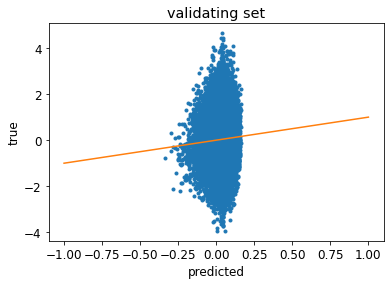

In [14]:
y_pred = model(X_train)
before_train = loss_fn(y_pred, y_train)
print('Test loss before training' , before_train.item())

plt.plot( model(X_train).detach().numpy(),y_train.numpy(),'.')
plt.plot([-1,1],[-1,1])
plt.title('validating set')
plt.xlabel('predicted')
plt.ylabel('true')

In [9]:
epoch = 100

epo_losses = []

model.train()

for i in tqdm(range(epoch)):
    # Forward pass
    y_pred = model(X_train)
    
    # Compute Loss
    loss = loss_fn(y_pred, y_train)
    epo_losses.append(loss.item())
    
    # update
    opt.zero_grad()
    loss.backward()
    opt.step()

100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


Text(0, 0.5, 'loss')

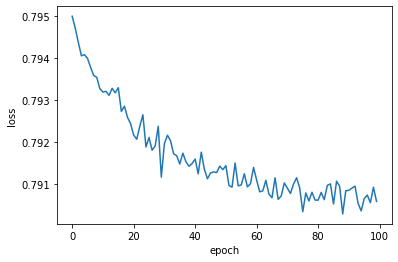

In [10]:
plt.plot(epo_losses)
plt.xlabel('epoch')
plt.ylabel('loss')

In [11]:
model.eval()
y_pred = model(X_val)
after_train = loss_fn(y_pred, y_val) 
print('Test loss after Training' , after_train.item())

Test loss after Training 0.7856815457344055


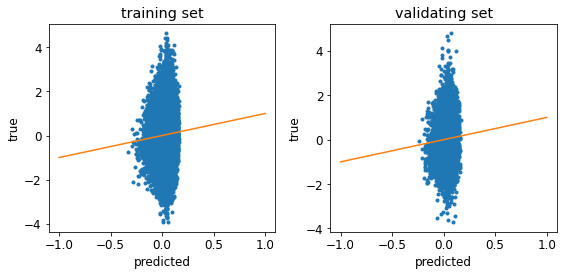

In [13]:
plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 12})

plt.subplot(121)
plt.plot( model(X_train).detach().numpy(),y_train.numpy(),'.')
plt.plot([-1,1],[-1,1])
plt.title('training set')
plt.xlabel('predicted')
plt.ylabel('true')

plt.subplot(122)
plt.plot( model(X_val).detach().numpy(),y_val.numpy(),'.')
plt.plot([-1,1],[-1,1])
plt.title('validating set')
plt.xlabel('predicted')
plt.ylabel('true')

plt.tight_layout()
plt.show()